In [67]:
import numpy as np
import ot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import W2_dist, BaseTransport, GaussianTransport, get_trajectories_for_plotting, \
                  calc_parsimony, get_desiderata

# We will be using data from  the UCI: Gas sensor array under dynamic gas mixtures Data Set
# Link: https://archive.ics.uci.edu/ml/datasets/gas+sensor+array+under+dynamic+gas+mixtures
data_dir = Path('data')

In [68]:
# Experiment hyperparamters
rng = np.random.RandomState(42)



In [69]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [70]:
!dir $data_dir

zsh:1: command not found: dir


## Loading and Preprocessing the data


In [71]:
from data_utils import load_and_preprocess_logistics_data
continuous_variables_indicies = [0,1,2]
# Pick the desired dataset combination
comparison_dict = {0: [0,1], 1: [2,3], 2: [4,5]}
comparison_id = 1
# n_samples = 'balanced'
n_samples = 1000
equal_week_split = True

X, Y, feature_names = load_and_preprocess_logistics_data(
            data_dir, rng, n_samples, return_column_names=True,equal_week_split=equal_week_split, comparison_id=
            comparison_id, comparison_dict=comparison_dict)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(feature_names)
print(X)
print(Y)



./00_simulate_data/Output Customer Data/customer_profile_2.csv
Comparing customer_profile_2 and customer_profile_3
Finished preprocessing logistic dataset. Split on customer_profile_2 and customer_profile_3 with resulting source shape: (1000, 3), target shape: (1000, 3).
['Connection', 'Weight', 'Unit_type']
[[ 1.         18.25089511 30.        ]
 [ 1.         18.69038044 20.        ]
 [ 1.          7.14836171 22.        ]
 ...
 [12.         21.29175348 20.        ]
 [12.         14.3457763  30.        ]
 [ 6.         12.96777395 22.        ]]
[[12.          5.05118538 25.        ]
 [17.         11.8140525  35.        ]
 [14.          4.72408727 30.        ]
 ...
 [ 5.          7.47428296 15.        ]
 [ 1.         14.26527439 10.        ]
 [12.         13.93735031 30.        ]]


## Performing Clustering

In [72]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        # Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [73]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [74]:
## Hyperparameters
max_clusters = 10

In [75]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 1.045, Par: 0.000, Inter: 0
Fid: 0.577, Par: 467.807, Inter: 1
Fid: 0.569, Par: 479.545, Inter: 2
Fid: 0.563, Par: 486.976, Inter: 3
Fid: 0.110, Par: 930.520, Inter: 4
Fid: 0.137, Par: 904.635, Inter: 5
Fid: 0.183, Par: 851.491, Inter: 6
Fid: 0.133, Par: 904.929, Inter: 7
Fid: 0.146, Par: 890.045, Inter: 8
Fid: 0.125, Par: 916.390, Inter: 9
Fid: 0.109, Par: 934.832, Inter: 10


In [76]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on customer_profile_2 and customer_profile_3:


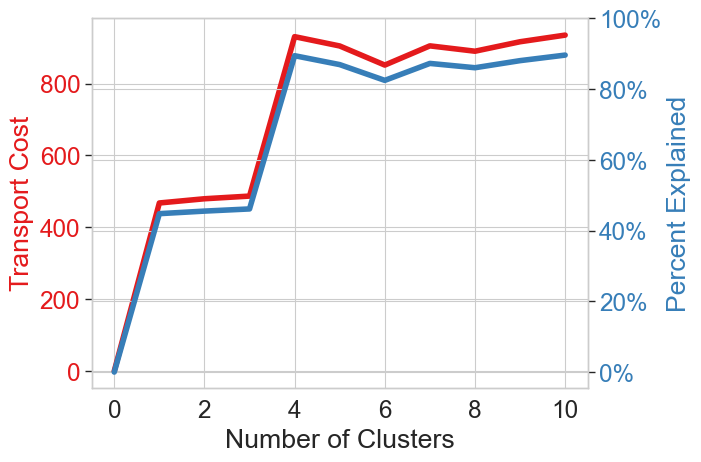

In [77]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)



print(f'Results with splitting on customer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}:')
if save_figures: plt.savefig(
    figure_dir / f'logitics_data_on_customer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

Starting 1 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_2_mean=[ 9.541 11.453 34.786]
		T(customer_profile_3)_mean=[11.078 11.251 22.425]

Starting 2 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_2_mean=[14.743 11.148 37.291]
		T(customer_profile_3)_mean=[16.686 11.078 23.217]
	Cluster: 1
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_2_mean=[ 4.909 11.725 32.556]
		T(customer_profile_3)_mean=[ 6.085 11.405 21.72 ]

Starting 3 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_2_mean=[ 4.675  8.999 30.683]
		T(customer_profile_3)_mean=[ 5.738  8.363 21.033]
	Cluster: 1
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_2_mean=[15.202  8.201 36.99 ]
		T(customer_profile_3)_mean=[16.866  8.203 23.208]
	Cluster: 2
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_2_mean=[ 9.627 17.178 37.248]
		T(customer_profile_3)_mean=[11.567 17.263 23.2

,Cluster,Distance
2,2,6.522120
5,5,6.635788
7,7,7.163112
9,9,7.217286
1,1,7.625999
8,8,7.643375
4,4,7.724785
3,3,8.572892
0,0,45.081740
6,6,45.124003


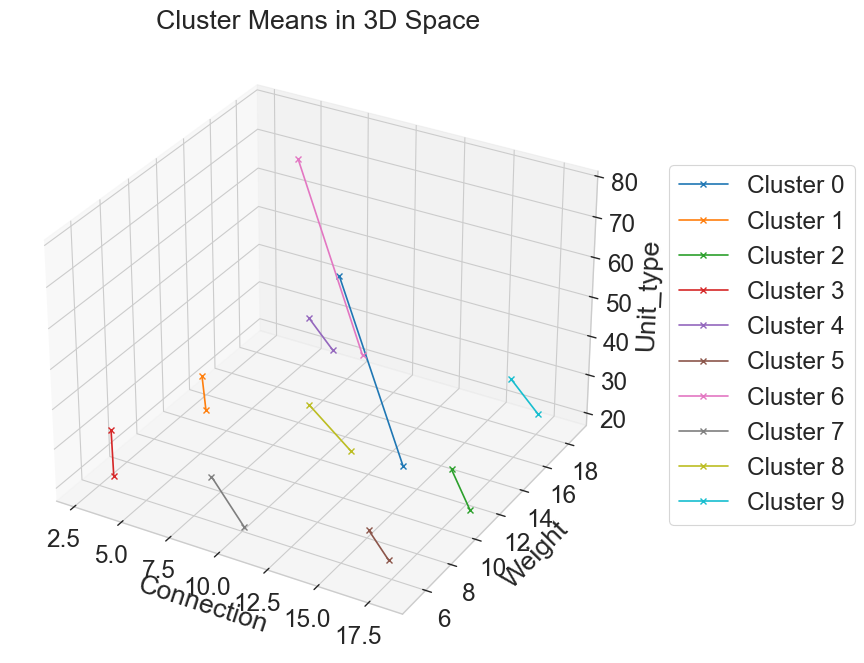

In [78]:
customer_profile_0_means = {}
customer_profile_1_means = {}
vis_clusters = max_clusters

for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    print(f'Starting {n_clusters} cluster results:')

    src_means = []
    tgt_means = []

    tgt = f'customer_profile_{comparison_dict[comparison_id][1]}'
    src = f'customer_profile_{comparison_dict[comparison_id][0]}'
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t\t\t     Names={[name[:3] for name in feature_names]}')
            src_mean = X[cluster_idx == labels].mean(axis=0)
            tgt_mean = Z_clusters[cluster_idx == labels].mean(axis=0)
            print(f'\t\t   {src}_mean={src_mean}')
            print(f'\t\tT({tgt})_mean={tgt_mean}')

            customer_profile_0_means[n_clusters] = src_means
            customer_profile_1_means[n_clusters] = tgt_means
            src_means.append(src_mean)
            tgt_means.append(tgt_mean)
        print()

# print(customer_profile_0_means)
# print(customer_profile_1_means)

# customer_profile_0_means = customer_profile_0_means[vis_clusters]
# customer_profile_1_means = customer_profile_1_means[vis_clusters]

# customer_profile_0_means = np.array(customer_profile_0_means)
# customer_profile_1_means = np.array(customer_profile_1_means)
print(customer_profile_0_means)
# print(customer_profile_1_means)
# # Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

distances = {}

for cluster_idx in range(vis_clusters):
    x_vals = [customer_profile_0_means[vis_clusters][cluster_idx][0], customer_profile_1_means[vis_clusters][cluster_idx][0]]
    y_vals = [customer_profile_0_means[vis_clusters][cluster_idx][1], customer_profile_1_means[vis_clusters][cluster_idx][1]]
    z_vals = [customer_profile_0_means[vis_clusters][cluster_idx][2], customer_profile_1_means[vis_clusters][cluster_idx][2]]
    

    distances[cluster_idx] = ((x_vals[0]-x_vals[1])**2 + (y_vals[0]-y_vals[1])**2 + (z_vals[0]-z_vals[1])**2)**0.5

    ax.plot(x_vals, y_vals, z_vals, marker='x', linestyle='-', label=f'Cluster {cluster_idx}')

distances = pd.DataFrame(distances.items(), columns=['Cluster', 'Distance'])
distances = distances.sort_values(by='Distance')

display(distances)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
ax.set_title('Cluster Means in 3D Space')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()    

,Dataset,C_max,K,V_max,lambd,sim_weeks,UT_list,weight_span,num_components,number_of_connections
2,2,20,71,70,0.020345,4,"[20, 22, 24, 30, 40, 80]","[3, 20]",3.0,2.0
3,3,20,71,50,0.039723,4,"[10, 15, 20, 25, 30, 35]","[3, 20]",3.0,5.0


,Cluster,Total_distance,Connections_diff,Weight_diff,Unit_diff
2,2,6.522120,1.340426,0.636634,6.351064
5,5,6.635788,0.877358,0.164605,6.575472
7,7,7.163112,2.224000,0.816329,6.760000
9,9,7.217286,1.494949,0.046774,7.060606
1,1,7.625999,0.362903,0.260511,7.612903
8,8,7.643375,2.439252,0.381590,7.233645
4,4,7.724785,1.120370,0.253862,7.638889
3,3,8.572892,0.643564,0.760009,8.514851
0,0,45.081740,2.515152,1.018497,45.000000
6,6,45.124003,3.342857,0.030739,45.000000


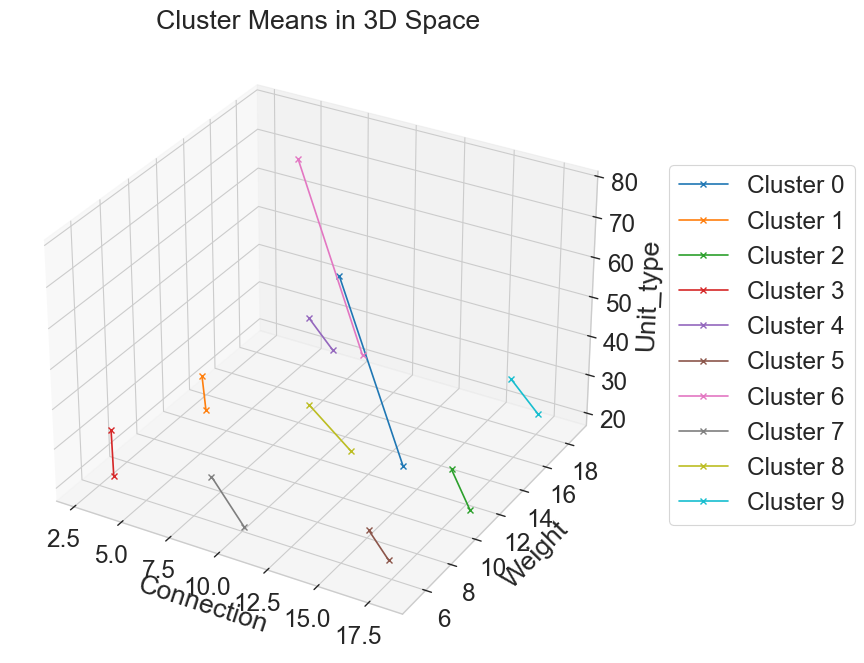

In [79]:
# importing experiment parameters
params =pd.read_csv('./00_simulate_data/Output Customer Data/params.csv')
params = params.iloc[comparison_dict[comparison_id]]
display(params)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


total_distance = []
weight_difference = []
unit_difference = []
connections_difference = []



for cluster_idx in range(vis_clusters):
    x_vals = [customer_profile_0_means[vis_clusters][cluster_idx][0], customer_profile_1_means[vis_clusters][cluster_idx][0]]
    y_vals = [customer_profile_0_means[vis_clusters][cluster_idx][1], customer_profile_1_means[vis_clusters][cluster_idx][1]]
    z_vals = [customer_profile_0_means[vis_clusters][cluster_idx][2], customer_profile_1_means[vis_clusters][cluster_idx][2]]
    
    total_distance.append(((x_vals[0]-x_vals[1])**2 + (y_vals[0]-y_vals[1])**2 + (z_vals[0]-z_vals[1])**2)**0.5)
    connections_difference.append(abs((x_vals[0]-x_vals[1])))
    weight_difference.append(abs((y_vals[0]-y_vals[1])))
    unit_difference.append(abs((z_vals[0]-z_vals[1])))
   
    ax.plot(x_vals, y_vals, z_vals, marker='x', linestyle='-', label=f'Cluster {cluster_idx}')

distances = pd.DataFrame({
    'Cluster': range(vis_clusters),
    'Total_distance': total_distance,
    'Connections_diff': connections_difference,
    'Weight_diff': weight_difference,
    'Unit_diff': unit_difference
})

distances = distances.sort_values(by='Total_distance')
display(distances)


output_path = f'./results_experiments/results_customer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}.csv'
distances.to_csv(output_path)

ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
ax.set_title('Cluster Means in 3D Space')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()    